# Modeling- Optimizing For Tournament Structure
- Robert Shaw, Sean Coleman, Spencer Evans, Daniel Alpert
- CS109a Project- Data Driven March Madness

---

In this file, we tune our model to the sturcture of the tournament. Using a simulation method, we will attempt to approxiate the maximum expected score (i.e. number of point under the ESPN scoring method).

We also present methods for biasing our predictions towards making "unique" brackets (i.e. those that are much different from choosing the higher seed). We also allow the location of the bias to change (i.e. induce a lot of early round upsets or late round upsets).

---

In [1]:
import march_madness_classes as mmc
import march_madness_games as mmg
import march_madness_models as mmm
import march_madness_train_and_tune as mmtt

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import Lasso as Lasso
from sklearn.ensemble import RandomForestClassifier as random_forest

In [2]:
# read in the dataset
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")
games = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")

seeds_arr = mmg.filter_into_seasons(seeds)
slots_arr = mmg.filter_into_seasons(slots)
games_arr = mmg.filter_into_seasons(games)

In [3]:
# extract predictors, chosen from the variable selection notebook
markov          = pd.read_csv("datasets/our_data/stationary", index_col=0)
rpi             = pd.read_csv("datasets/our_data/rpi", index_col=0)
bad_losses      = pd.read_csv("datasets/our_data/bad_losses", index_col=0)

# seeds
seed_matrix_df  = pd.read_csv("datasets/our_data/team_summary_data/seeds_matrix", index_col=0)

In [4]:
# get data into correct format
predictor_names = ["min_index_id", "max_index_id", "markov","rpi","bad_losses"] 

# package the predictors into an array
predictor_dfs = [markov, rpi, bad_losses] 

In [19]:
train_test_arr = []

window   = 3
min_year = 2001
max_year = 2014

year_range = range(min_year, max_year)

# generate our train test split for each year
for year in year_range:
    # do the split for the current year
    train_test_tuple = mmtt.train_test_split(window, 
                                             year, 
                                             seeds_arr, 
                                             slots_arr, 
                                             games_arr, 
                                             predictor_names, 
                                             predictor_dfs)
    
    # add to our array
    train_test_arr.append(train_test_tuple)

In [21]:
# our cross validated value of c, from variable selection notebook
c = 1
variables = ["markov","rpi","bad_losses"] 

# models and scalers to be fit
models  = []
scalers = []

for year in year_range:
        # get train data
        train_x = train_test_arr[year - min_year][0][variables]
        train_y = train_test_arr[year - min_year][1].values[:, 0]

        # get cross validation set
        cross_x = train_test_arr[year - min_year][2][variables]
        cross_y = train_test_arr[year - min_year][3].values[:, 0]

        # scaling
        scaler = StandardScaler().fit(train_x)
        scaled_train_x = scaler.transform(train_x)
        scaled_cross_x = scaler.transform(cross_x)

        # init model
        model = LogReg(C=c)

        # fit model
        model.fit(scaled_train_x, train_y)
        
        # append to our lis of models
        models.append(model)
        scalers.append(scaler)

---

## 1) Simulator vs Greedy

---

#### Setup and Train

In [22]:
# setup simulator
simulators = []

i = 0
# iterate years
for year in year_range: 
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # setup head to head model
    head_to_head_model_year = mmm.ModelPredictor(models[i], scalers[i], predictor_dfs, year, simulation=True)
    
    # setup simulator
    simulators.append(mmc.Simulator(seeds_year, slots_year, head_to_head_model_year))
    
    i = i + 1

In [23]:
# run simulations
i = 0
for year in year_range:
    # run simulation
    points = simulators[i].simulate_tournament(300) 
    
    # predict bracket based on the simulation
    bracket = simulators[i].predict_tournament()
    
    i = i + 1
    
    print year

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [24]:
# run greedy and top seed tourneys
year = min_year
greedy_tourneys   = []
top_seed_tourneys = []
actual_tourneys   = []

# analyze results for all simulations
i = 0
for year in year_range:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get actual models
    actual_model = mmm.ActualTournament(games_arr[year-1985])
    actual_tourneys.append(mmc.Tournament(seeds_year, slots_year, actual_model, include_scoring_dif=False))
    
    # get greedy models
    greedy_model = mmm.ModelPredictor(models[i], scalers[i], predictor_dfs, year, simulation=False)
    greedy_tourneys.append(mmc.Tournament(seeds_year, slots_year, greedy_model, include_scoring_dif=False))
    
    # get top seed models
    top_seed_model = mmm.BasicPredictor()
    top_seed_tourneys.append(mmc.Tournament(seeds_year, slots_year, top_seed_model, include_scoring_dif=False))
    
    year = year + 1
    i = i + 1

---

#### Scoring

In [26]:
year = min_year

simulator_scores = np.zeros(len(year_range))
simulator_accuracys = np.zeros(len(year_range))

# analyze results for all simulations
i = 0
for simulator in simulators:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get actual models
    actual_model = mmm.ActualTournament(games_arr[year-1985])
    actual_tourney = mmc.Tournament(seeds_year, slots_year, actual_model, include_scoring_dif=False)
    
    # score tournament 
    simulator_scores[i], simulator_accuracys[i] = simulator.score_tournament(actual_tourney, print_res=False)
    
    year = year + 1
    i = i + 1

In [27]:
# buffers
greedy_scores = np.zeros(len(year_range))
greedy_accuracys = np.zeros(len(year_range))

top_seed_scores = np.zeros(len(year_range))
top_seed_accuracys = np.zeros(len(year_range))

# analyze results 
year = min_year
i = 0
for i in range(len(year_range)):
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get models
    actual_tourney = actual_tourneys[i]
    greedy_tourney = greedy_tourneys[i]
    top_seed_tourney = top_seed_tourneys[i]
    
    # score tournaments
    greedy_scores[i], greedy_accuracys[i] = greedy_tourney.score_tournament(actual_tourney, print_res=False)
    top_seed_scores[i], top_seed_accuracys[i] = top_seed_tourney.score_tournament(actual_tourney, print_res=False)
    
    year = year + 1
    i = i + 1

Avg Score Top Seed   : 863.846153846
Avg Score Greedy     : 960.0
Avg Score Simulation : 970.769230769


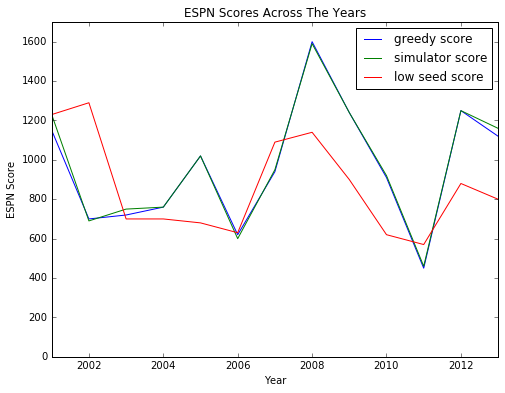

In [43]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_range, greedy_scores, color="b", label="greedy score")
ax.plot(year_range, simulator_scores, color="g", label="simulator score")
ax.plot(year_range, top_seed_scores, color="r", label="low seed score")
ax.set_xlim([2001, 2013])
ax.set_ylim([0, 1700])
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Scores Across The Years")
ax.legend()

print "Avg Score Top Seed   : {}".format(np.average(top_seed_scores))
print "Avg Score Greedy     : {}".format(np.average(greedy_scores))
print "Avg Score Simulation : {}".format(np.average(simulator_scores))

In [40]:
n = len(greedy_tourneys)

greedy_n_dif = np.zeros(n)
greedy_n_correct = np.zeros(n)
greedy_n_other_correct = np.zeros(n)

greedy_n_dif_sim = np.zeros(n)
greedy_n_correct_sim = np.zeros(n)
greedy_n_other_correct_sim = np.zeros(n)

simulator_n_dif = np.zeros(n)
simulator_n_correct = np.zeros(n)
simulator_n_other_correct = np.zeros(n)

# iterate through our entire list
for i in range(n):
    # comapre
    greedy_n_dif_sim[i], greedy_n_correct_sim[i], greedy_n_other_correct_sim[i] = greedy_tourneys[i].compare_to_dif_tournament(actual_tourneys[i], simulators[i].tournament_prediction, print_res=False)
    
    greedy_n_dif[i], greedy_n_correct[i], greedy_n_other_correct[i] = greedy_tourneys[i].compare_to_dif_tournament(actual_tourneys[i], top_seed_tourneys[i], print_res=False)
    
    simulator_n_dif[i], simulator_n_correct[i], simulator_n_other_correct[i] = simulators[i].tournament_prediction.compare_to_dif_tournament(actual_tourneys[i], top_seed_tourneys[i], print_res=False)

Avg N Games Dif Simulator : 7.76923076923
Avg N Games Dif Greedy    : 8.46153846154


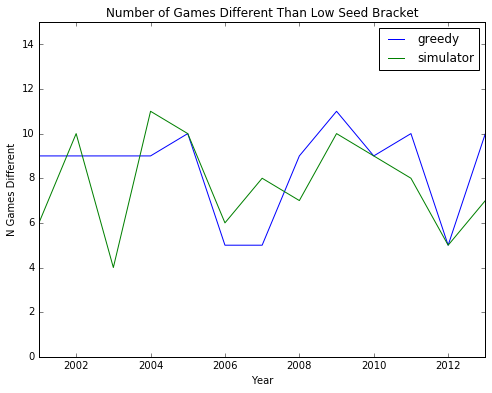

In [48]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_range, greedy_n_dif, color="b", label="greedy")
ax.plot(year_range, simulator_n_dif, color="g", label="simulator")
ax.set_xlim([2001, 2013])
ax.set_ylim([0,15])
ax.set_xlabel("Year")
ax.set_ylabel("N Games Different")
ax.set_title("Number of Games Different Than Low Seed Bracket")
ax.legend()

print "Avg N Games Dif Simulator : {}".format(np.average(simulator_n_dif))
print "Avg N Games Dif Greedy    : {}".format(np.average(greedy_n_dif))

Avg N Games Dif Simulator vs Greedy: 2.92307692308


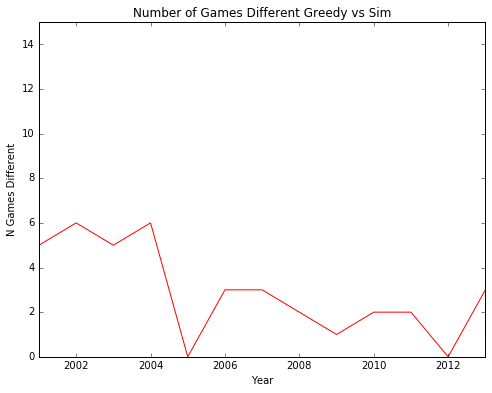

In [49]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(year_range, greedy_n_dif_sim, color="r")
ax.set_xlim([2001, 2013])
ax.set_ylim([0,15])
ax.set_xlabel("Year")
ax.set_ylabel("N Games Different")
ax.set_title("Number of Games Different Greedy vs Sim")
ax.legend()

print "Avg N Games Dif Simulator vs Greedy: {}".format(np.average(greedy_n_dif_sim))

---

## 2) Increase Number Of Upsets

---

In [74]:
scores_biased_models = np.zeros(max_year-min_year)

In [98]:
# fit biased models
biased_tourneys = []
i = 0
for year in year_range:
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # setup head to head model, with bias
    biased_model = mmm.ModelPredictor(models[i], 
                                     scalers[i],
                                     predictor_dfs,
                                     year, 
                                     simulation=False, 
                                     higher_seed_bias=True,
                                     seeds_df=seeds_year, 
                                     higher_seed_bias_delta=.04)
        

    biased_tourneys.append(mmc.Tournament(seeds_year, slots_year, biased_model, include_scoring_dif=False))
                
    i = i + 1

In [99]:
# score biased models
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # score the biased models
    scores_biased_models[i], x = biased_tourneys[i].score_tournament(actual_tourney)

    i = i + 1

Avg Score Top Seed : 863.846153846
Avg Score Unbiased : 960.0
Avg Score Biased   : 924.615384615


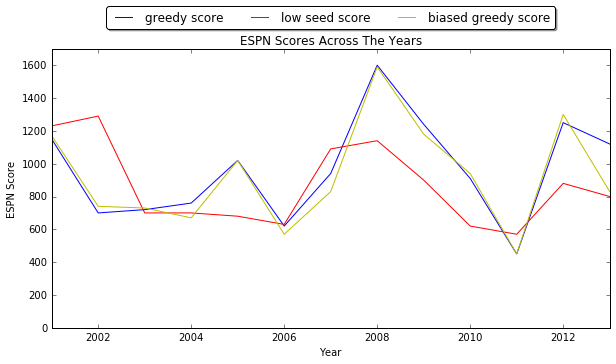

In [209]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(year_range, greedy_scores, color="b", label="greedy score")
ax.plot(year_range, top_seed_scores, color="r", label="low seed score")
ax.plot(year_range, scores_biased_models, color="y", label="biased greedy score")
ax.set_xlim([2001, 2013])
ax.set_ylim([0, 1700])
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Scores Across The Years")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


print "Avg Score Top Seed : {}".format(np.average(top_seed_scores))
print "Avg Score Unbiased : {}".format(np.average(greedy_scores))
print "Avg Score Biased   : {}".format(np.average(scores_biased_models))

In [102]:
n = len(greedy_tourneys)

bias_top_seed_n_dif = np.zeros(n)
bias_top_seed_n_correct = np.zeros(n)
bias_top_seed_n_other_correct = np.zeros(n)

bias_greedy_n_dif = np.zeros(n)
bias_greedy_n_correct = np.zeros(n)
bias_greedy_n_other_correct = np.zeros(n)

# iterate through our entire list
for i in range(n):
    # comapre
    bias_top_seed_n_dif[i], bias_top_seed_n_correct[i], bias_top_seed_n_other_correct[i] = biased_tourneys[i].compare_to_dif_tournament(actual_tourneys[i], top_seed_tourneys[i], print_res=False)
    
    bias_greedy_n_dif[i], bias_greedy_n_correct[i], bias_greedy_n_other_correct[i] = biased_tourneys[i].compare_to_dif_tournament(actual_tourneys[i], greedy_tourneys[i], print_res=False)

Avg N Games Dif Unbiased Low Seed : 8.46153846154
Avg N Games Dif Biased Low Seed   : 12.7692307692


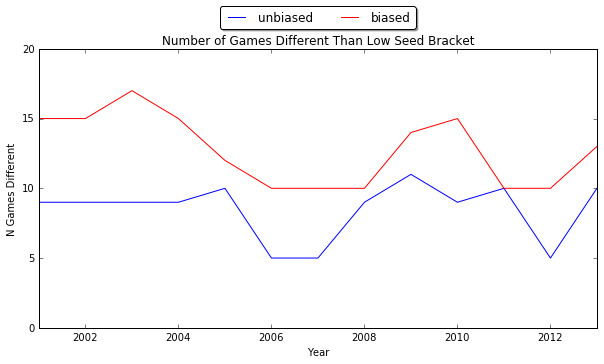

In [109]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(year_range, greedy_n_dif, color="b", label="unbiased")
ax.plot(year_range, bias_top_seed_n_dif, color="r", label="biased")
ax.set_xlim([2001, 2013])
ax.set_ylim([0,20])
ax.set_xlabel("Year")
ax.set_ylabel("N Games Different")
ax.set_title("Number of Games Different Than Low Seed Bracket")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

print "Avg N Games Dif Unbiased Low Seed : {}".format(np.average(greedy_n_dif))
print "Avg N Games Dif Biased Low Seed   : {}".format(np.average(bias_top_seed_n_dif))

---

## 3) Simulation With Bias

---

In [126]:
biased_simulator_scores = np.zeros(max_year-min_year)

In [123]:
reload(mmc)

<module 'march_madness_classes' from 'march_madness_classes.py'>

In [124]:
# fit biased models
biased_simulators = []
i = 0
for year in year_range:
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # setup head to head model, with bias
    biased_model = mmm.ModelPredictor(models[i], 
                                     scalers[i],
                                     predictor_dfs,
                                     year, 
                                     simulation=True, 
                                     higher_seed_bias=True,
                                     seeds_df=seeds_year, 
                                     higher_seed_bias_delta=.04)
        

    biased_simulators.append(mmc.Simulator(seeds_year, slots_year, biased_model))
                
    i = i + 1

In [125]:
# run simulations
i = 0
for year in year_range:
    # run simulation
    biased_simulators[i].simulate_tournament(300) 
    
    # predict bracket based on the simulation
    biased_simulators[i].predict_tournament()
    
    i = i + 1
    
    print year

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


In [128]:
# analyze results for all simulations
i = 0
year = min_year
for simulator in biased_simulators:
    # get data from our db
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    # get actual models
    actual_model = mmm.ActualTournament(games_arr[year-1985])
    actual_tourney = mmc.Tournament(seeds_year, slots_year, actual_model, include_scoring_dif=False)
    
    # score tournament 
    biased_simulator_scores[i], x = simulator.score_tournament(actual_tourney, print_res=False)
    
    year = year + 1
    i = i + 1

Avg Score Top Seed           : 863.846153846
Avg Score Unbiased Simulator : 970.769230769
Avg Score Biased Greedy      : 924.615384615
Avg Score Biased Simulator   : 922.307692308


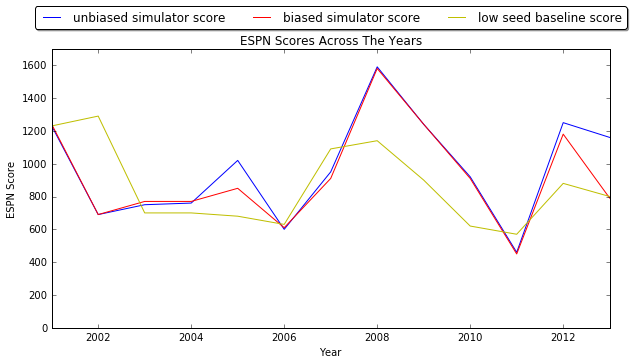

In [135]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(year_range, simulator_scores, color="b", label="unbiased simulator score")
ax.plot(year_range, biased_simulator_scores, color="r", label="biased simulator score")
ax.plot(year_range, top_seed_scores, color="y", label="low seed baseline score")
ax.set_xlim([2001, 2013])
ax.set_ylim([0, 1700])
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Scores Across The Years")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


print "Avg Score Top Seed           : {}".format(np.average(top_seed_scores))
print "Avg Score Unbiased Simulator : {}".format(np.average(simulator_scores))
print "Avg Score Biased Greedy      : {}".format(np.average(scores_biased_models))
print "Avg Score Biased Simulator   : {}".format(np.average(biased_simulator_scores))

In [137]:
n = len(greedy_tourneys)

bias_sim_n_dif = np.zeros(n)
bias_sim_n_correct = np.zeros(n)
bias_sim_n_other_correct = np.zeros(n)


# iterate through our entire list
for i in range(n):
    # comapre
    bias_sim_n_dif[i], bias_sim_n_correct[i], bias_sim_n_other_correct[i] = biased_simulators[i].tournament_prediction.compare_to_dif_tournament(actual_tourneys[i], top_seed_tourneys[i], print_res=False)

Avg N Games Dif Unbiased Sim Low Seed : 7.76923076923
Avg N Games Dif Biased Sim Low Seed   : 10.1538461538


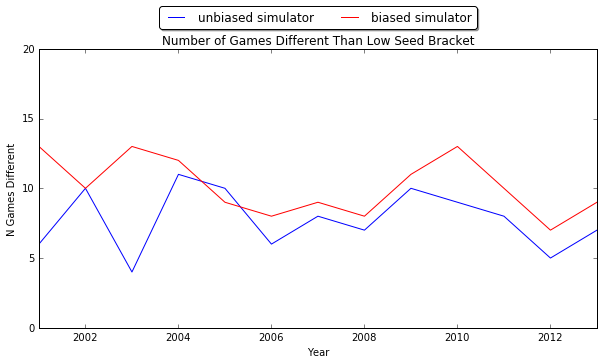

In [139]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(year_range, simulator_n_dif, color="b", label="unbiased simulator")
ax.plot(year_range, bias_sim_n_dif, color="r", label="biased simulator")
ax.set_xlim([2001, 2013])
ax.set_ylim([0,20])
ax.set_xlabel("Year")
ax.set_ylabel("N Games Different")
ax.set_title("Number of Games Different Than Low Seed Bracket")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

print "Avg N Games Dif Unbiased Sim Low Seed : {}".format(np.average(simulator_n_dif))
print "Avg N Games Dif Biased Sim Low Seed   : {}".format(np.average(bias_sim_n_dif))

---

## 4) Late vs Early Round Upsets

---

In [206]:
early_round_upsets = {6:0, 5:0, 4:0, 3:0, 2:20, 1:40}
later_round_upsets = {6:10, 5:10, 4:10, 3:30, 2:20, 1:0}

early_round_upsets_tourneys = []
later_round_upsets_tourneys = []

i = 0
for year in year_range:

    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]
    
    bias = .005

    # setup head to head model, with bias in the early rounds
    early_round_bias = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=bias, 
                                      cooling = early_round_upsets)
    
    # setup head to head model, with bias in the early rounds
    later_round_bias = mmm.ModelPredictor(models[i], 
                                      scalers[i],
                                      predictor_dfs,
                                      year, 
                                      simulation=False, 
                                      higher_seed_bias=True,
                                      seeds_df=seeds_year, 
                                      higher_seed_bias_delta=bias, 
                                      cooling = later_round_upsets)
    
    
    # run tournaments
    early_round_upsets_tourneys.append(mmc.Tournament(seeds_year, slots_year, early_round_bias, include_scoring_dif=False))
    later_round_upsets_tourneys.append(mmc.Tournament(seeds_year, slots_year, later_round_bias, include_scoring_dif=False))
    
    i = i + 1
  

In [207]:
scores_early_round_upsets = np.zeros(max_year-min_year)
scores_later_round_upsets = np.zeros(max_year-min_year)

# score biased models with cooling
i = 0
for year in year_range:
    # actual results
    actual_tourney = actual_tourneys[i]
    
    # get data needed
    seeds_year = seeds_arr[year-1985] 
    slots_year = slots_arr[year-1985] 
    games_year = games_arr[year-1985]

    # score the biased models
    scores_early_round_upsets[i] = early_round_upsets_tourneys[i].score_tournament(actual_tourney)[0]
    scores_later_round_upsets[i] = later_round_upsets_tourneys[i].score_tournament(actual_tourney)[0]  

    i = i + 1

Avg Score Top Seed           : 863.846153846
Avg Score Unbiased           : 960.0
Avg Score Biased Later Round : 858.461538462
Avg Score Biased Early Round : 916.923076923


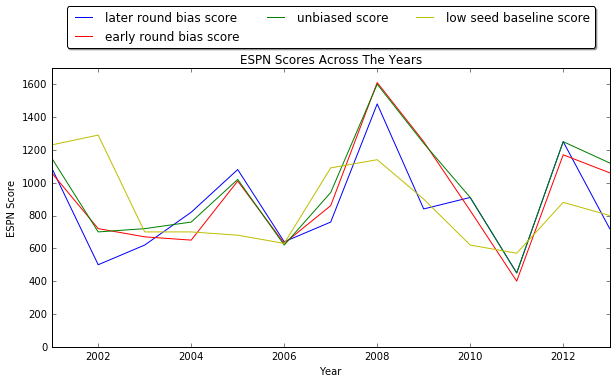

In [208]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(year_range, scores_later_round_upsets, color="b", label="later round bias score")
ax.plot(year_range, scores_early_round_upsets, color="r", label="early round bias score")
ax.plot(year_range, greedy_scores, color="g", label="unbiased score")
ax.plot(year_range, top_seed_scores, color="y", label="low seed baseline score")
ax.set_xlim([2001, 2013])
ax.set_ylim([0, 1700])
ax.set_xlabel("Year")
ax.set_ylabel("ESPN Score")
ax.set_title("ESPN Scores Across The Years")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


print "Avg Score Top Seed           : {}".format(np.average(top_seed_scores))
print "Avg Score Unbiased           : {}".format(np.average(greedy_scores))
print "Avg Score Biased Later Round : {}".format(np.average(scores_later_round_upsets))
print "Avg Score Biased Early Round : {}".format(np.average(scores_early_round_upsets))